In [ ]:
!nvidia-smi

Fri Jul  7 06:59:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    38W / 300W |      0MiB / 16384MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install transformers

  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
  Using cached huggingface_hub-0.16.2-py3-none-any.whl (268 kB)
  Using cached regex-2023.6.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (755 kB)
  Using cached tokenizers-0.13.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached safetensors-0.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install -q datasets

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset 
from transformers import AutoProcessor, BlipForConditionalGeneration

In [ ]:
dataset = load_dataset('csv', data_files='file_highres.csv')
#dataset = load_dataset('dataset/images')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/jupyter/.cache/huggingface/datasets/csv/default-6ae0f9ae9ea0542d/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# dataset['train'][0]["image"]
dataset['train'][0]['image_link']

'dataset_highres/images/1163.jpg'

In [ ]:
dataset['train'][0]['description']

'Nike Sahara Team India Fanwear Round Neck Jersey'

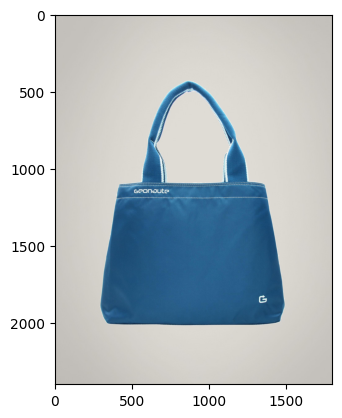

In [ ]:
img = mpimg.imread(dataset['train'][66]['image_link'])
imgplot = plt.imshow(img)
plt.show()


In [ ]:

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        #encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        encoding = self.processor(images=mpimg.imread(item["image_link"]), text=item["description"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
train_dataset = ImageCaptioningDataset(dataset['train'], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
        #print(idx)
        try:
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)

            loss = outputs.loss

            #print(idx,'/',epoch,"Loss:", loss.item())

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
    
    
        except ValueError:
            pass
    
    print("Loss:", loss.item())

Epoch: 0
Loss: 1.3781362771987915
Epoch: 1
Loss: 1.3756496906280518
Epoch: 2
Loss: 1.375218391418457
Epoch: 3
Loss: 1.3755568265914917
Epoch: 4
Loss: 1.3658685684204102
Epoch: 5
Loss: 1.3639625310897827
Epoch: 6
Loss: 1.363574743270874
Epoch: 7
Loss: 1.3625168800354004
Epoch: 8
Loss: 1.3604204654693604
Epoch: 9
Loss: 1.3608057498931885


In [ ]:
torch.save(model,'models/model_highres.pt')